<img src="img/Logo-Zillow.jpeg" width=800 height=800 />

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import acquire
import prepare
import model


import warnings
warnings.filterwarnings("ignore")

# Overall Project Plan
## Business Goals
- Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties. Namely, find a way to **create a better model than the one the Data Science team already has.**
- Find the key drivers of property value for single family properties.
- Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.
- Make recommendations on what works or doesn't work in prediction these homes' values.
---
## Data Science Pipeline

- [**Acquire**](#Data-Acquisition) data from the Codeup SQL Database. Create an acquire.py file containing functions to automate the process.
    - Initial inquiry into the data to see the shape and layout of things.
- Clean and [**prepare**](#Data-Preparation) data for the explore phase. Create prepare.py to store functions I create to automate the cleaning and preperation process. Separate train, validate, test subsets and scaled data.
- Begin [**exploration**](#Data-Exploration-(Exploratory-Data-Analysis)) of the data and ask questions leading to clarity of what is happening in the data. 
    - Clearly define at least three hypotheses, set an alpha, run any statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
- Create at least three different regression [**models**](#Modeling).
    - Evaluate models on train and validate datasets. Do further hyperparamter tuning to find the best performing models.
- Choose the model with that performs the best. Do any final tweaking of the model. Automate modeling functions and put them into a model.py file.
- Evaluate final model on the test dataset.
---
## Presentation
- Construct a Final Report Notebook wherein I show how I arrived at the MVP model. Throughout the notebook, document conclusions, takeaways, and next steps.
- Present my findings to my data science team using said Final Report Notebook.
    - Conlusions, takeaways, next steps
---
## Github repo
- Create README.md with data dictionary, project and business goals, initial hypothesis and an executive summary

# Executive Summary
- The features found to be key drivers of the property value for Single Family Properties were:
    - calculatedfinishedsquarefeet and fips/county
- Notably homes in Los Angeles county were more disparate than homes on either Orange or Ventura counties. Request further time to dive deeper into the data collected for Los Angeles county to see if I can develop a better performing model.

**Recommendations**

- The exploration of the data and subsequent modeling show that developing individual models for smaller subsets of similar homes will result in better predictive models.
    - For the future, I would like to create models for specific subgroups: e.g.
        - 0 - 50% group 
        - 50 - 90% group
        - Top 10% group
- Consider requiring more accurate reporting on listing creation from realtors. This will allow a future analysis to determine usable features.

### Data Acquisition

In [2]:
df = acquire.get_zillow()

In [3]:
df = acquire.clean_zillow(df)
df.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,yearbuilt,county,taxvaluedollarcnt
0,4,3.0,3.0,2123,7310.0,96978.0,1959,orange,569452.0
1,3,2.0,2.0,1230,4142.0,96046.0,1926,los_angeles,29770.0
2,2,1.0,1.0,600,7043.0,97003.0,1948,orange,234307.0
3,4,2.0,2.0,1463,7519.0,96342.0,1957,los_angeles,109437.0
4,4,2.5,2.0,2184,8569.0,96383.0,1978,ventura,713482.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51474 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51474 non-null  uint8  
 1   bathroomcnt                   51474 non-null  float16
 2   calculatedbathnbr             51474 non-null  float16
 3   calculatedfinishedsquarefeet  51474 non-null  uint16 
 4   lotsizesquarefeet             51474 non-null  float64
 5   regionidzip                   51474 non-null  float64
 6   yearbuilt                     51474 non-null  uint16 
 7   county                        51474 non-null  object 
 8   taxvaluedollarcnt             51474 non-null  float64
dtypes: float16(2), float64(3), object(1), uint16(2), uint8(1)
memory usage: 2.4+ MB


After cleaning, I am left with a dataset which is applicable to homes with the following characteristics:
- A lot size of less than 300,000 sq ft. (Roughly seven acres.)
- A calculated sq footage of less than 8500 sq ft.
- A tax value of less than $4 million.

### Data Preparation

In [5]:
train, validate, test = prepare.split_zillow(df)
train_scaled, validate_scaled, test_scaled = prepare.data_scaler(train, validate, test, columns_to_scale=(df.drop(columns = ['county', 'taxvaluedollarcnt']).columns))

In [6]:
train.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,yearbuilt,county,taxvaluedollarcnt
23156,2,2.0,2.0,1538,8370.0,96424.0,1938,los_angeles,102269.0
2568,4,2.0,2.0,1176,6096.0,96464.0,1954,los_angeles,324566.0
21142,4,3.5,3.0,2288,2920.0,97035.0,2004,orange,709000.0
697,3,2.0,2.0,1603,5859.0,96111.0,1947,los_angeles,351733.0
24151,3,2.5,2.0,2463,7306.0,97084.0,2004,ventura,610000.0


In [7]:
train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,yearbuilt,county,taxvaluedollarcnt
23156,0.125,0.1250,0.125,0.151623,0.027058,0.001455,0.434783,los_angeles,102269.0
2568,0.375,0.1250,0.125,0.107287,0.019260,0.001587,0.550725,los_angeles,324566.0
21142,0.375,0.3125,0.250,0.243478,0.008368,0.003467,0.913043,orange,709000.0
697,0.250,0.1250,0.125,0.159584,0.018447,0.000425,0.500000,los_angeles,351733.0
24151,0.250,0.1875,0.125,0.264911,0.023409,0.003629,0.913043,ventura,610000.0


Subsets train, validate, and test are ready for EDA.

Subsets train_scaled, validate_scaled, test_scaled ready for modeling after EDA is complete.

They represent the same data.

### Data Exploration (Exploratory Data Analysis)

My thoughts from before the data analysis.
- I suspect most of the features will be postively correlated in some way with the target. Though not all my be strong.
- I think lotsizesquarefeet and calculatedfinishedsquarefeet will have the strongest relationship with the target.
- I'm unsure how strongly bathroomcnt will correlate, but I suspet bedroomcnt will be relatively strong.
- I don't think regionidzip will have any significant relationship with the target as these are actually categorical data in numerical form.

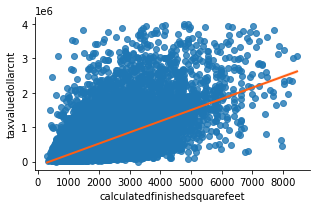

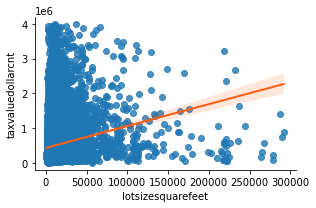

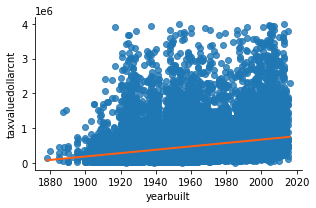

In [8]:
# Visualizing the continuous features against the target value 'taxvaluedollarcnt'
columns_to_viz = train.select_dtypes('number').drop(columns=['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedbathnbr', 'regionidzip']).columns.tolist()
for column in columns_to_viz:
    sns.lmplot(x = column, y = 'taxvaluedollarcnt', data = train, line_kws={'color': '#FF5E13', 'linewidth': 2},  height=3, aspect=1.5)
    plt.show()

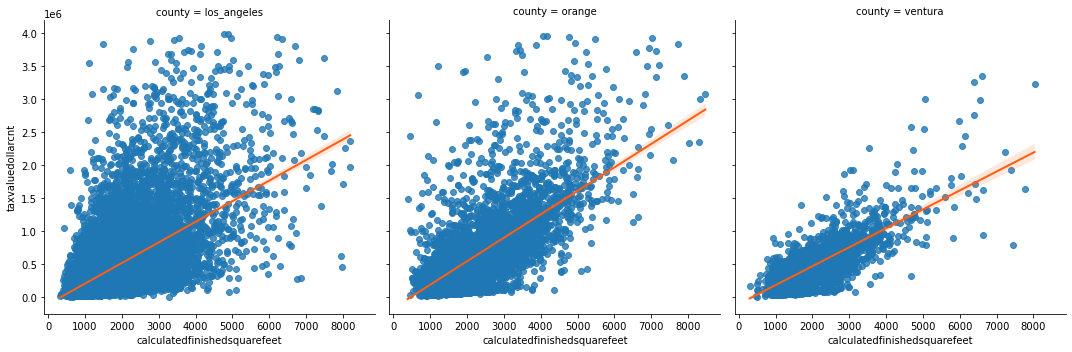

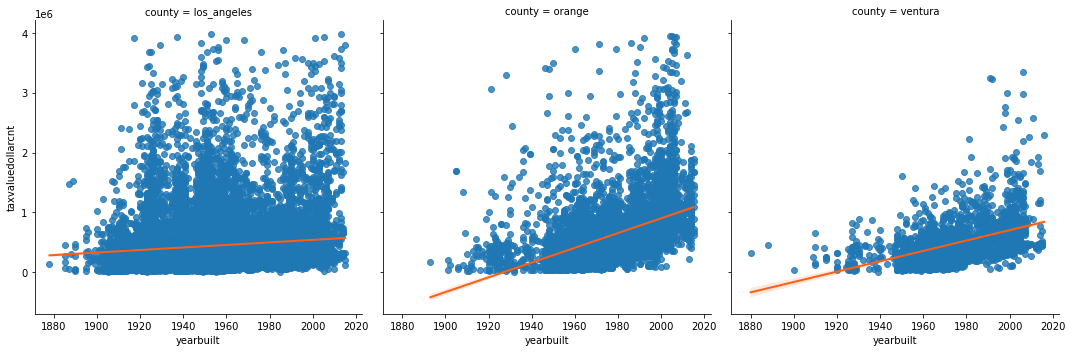

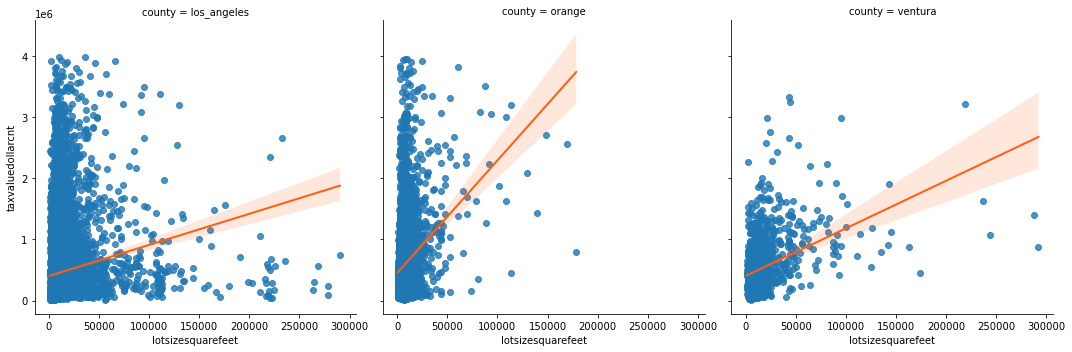

In [9]:
# Making visualizations of some of the data separated out by county to see if thee is any differences
for column in ['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet']:
    sns.lmplot(x=column, y='taxvaluedollarcnt', data=train, height=5, col='county', line_kws={'color': '#FF5E13', 'linewidth': 2})

### Takeaways from visualizations separated by county categorical

There are some major differences when seperating out by county, specifically on calculatefinishedsquarefeet and yearbuilt. In fact yearbuilt looked like junk when plotted against the whole data but when pulled out it looks like a good predictor for Orange and Ventura county but not for Los Angeles county.

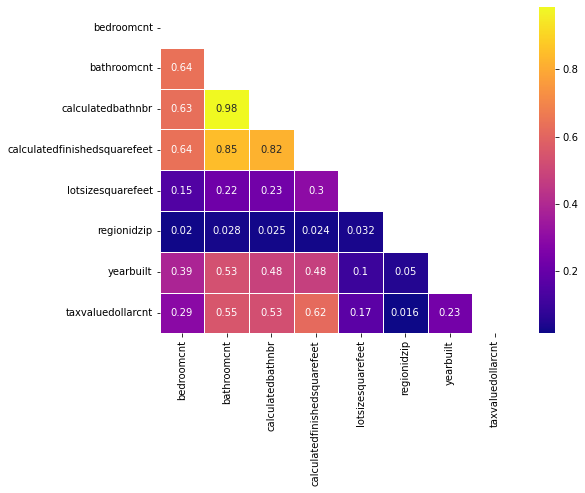

In [10]:
train_corr = train.drop(columns=['county']).corr()
mask = np.zeros_like(train_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8,6))
sns.heatmap(train_corr, cmap='plasma', annot=True, linewidth=0.5, mask = mask)

plt.show()

### Takeaways from heatmap of correlations
Looking at this heatmap, I'm not super encouraged by the correlations I have here. Nothing stands out as being particularly strongly correlated to the target.
- Bathroomcnt and calculatedbathnbr are essentially the same thing as they are correrlated at .98.
    - Because of this I should pick the feature that has the best correlation with the target and drop the other.
    - Since bathroomcnt is .55 and calculatedbathnbr is .53, I will keep bathroomcnt and drop the other when modeling.
- Bedroomcnt is .29 so while not strong I will include it initially in my model
- The strongest relationship to the target variable is calculatedfinishedsquarefeet at .62
- Suprisingly, lotsizesquarefeet is the weakest correlation of all the continuous variables; I will not be using this in my model.
- Yearbuilt has a weak enough correlation that I will leave it out of my model initially.
- I will not be including regionidzip as this is a categorical variable represented numerically.

<center><img src="img/correlations_by_county_v2.jpg" width=800 height=800 /></center>


### Takeaways from heatmap of correlations split by counties
These separated heatmaps seem to indicate that there is a difference between counties in certain featues when correlated to the target.
- Bathroomcnt and calculatedbathnbr are still essentially the same thing.
- All other variables have a stronger correlation in Orange and Ventura County, whereas everything else is weaker in Los Angeles county.
    - Maybe make separate models based on county.
    
- I need to do some hypothesis testing to see if my findings about these correlations are actually statistically significant.

## Hypothesis testing

##### Hypothesis 1:

$H_{0}$ Homes in Orange County and Ventura County have a lower or equal taxvaluedollarcnt than Los Angeles County.

$H_{a}$ Homes in Orange County and Ventura County have a higher taxvaluedollarcnt than Los Angeles County.


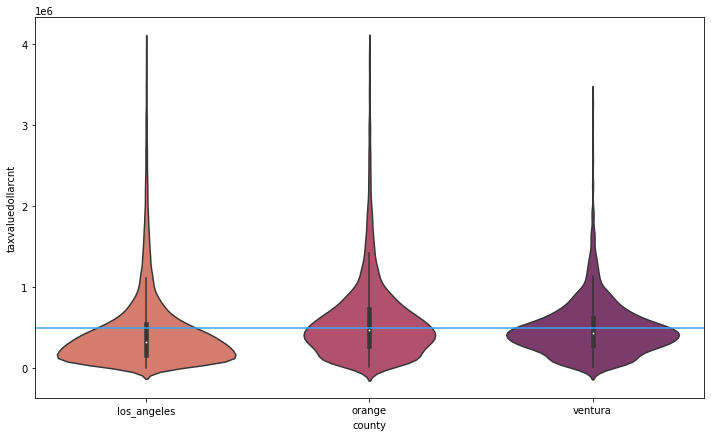

In [11]:
plt.figure(figsize=(12,7))
sns.violinplot(data = train, y = 'taxvaluedollarcnt', x = 'county', palette = 'flare')
plt.axhline(train.taxvaluedollarcnt.mean(), color = '#38a4fc')
plt.show()

In [12]:
# Setting variables
alpha = .05

orange_ventura = train[(train.county == 'orange') | (train.county == 'ventura')]
la_county = train[train.county == 'los_angeles']

# Checking for variance with levene
stats.levene(orange_ventura.taxvaluedollarcnt, la_county.taxvaluedollarcnt)
# No equal variance for these two groups

LeveneResult(statistic=17.9569945706127, pvalue=2.2665436929199795e-05)

In [13]:
t, p = stats.ttest_ind(orange_ventura.taxvaluedollarcnt, la_county.taxvaluedollarcnt, equal_var=False)

(p/2) < alpha, t

(True, 19.767291526267048)

Because p/2 is less than alpha and the t value is positive, I can reject the null hypothesis. Homes in Orange county and Ventura county have a higher taxvaluedollarcnt than homes in Los Angeles county.

##### Hypothesis 2

$H_{0}$ There is no linear correlation between calculatedfinishedsquarefeet and taxvaluedollarcnt.

$H_{a}$ There is a linear correlation between calculatedfinishedsquarefeet and taxvaluedollarcnt.

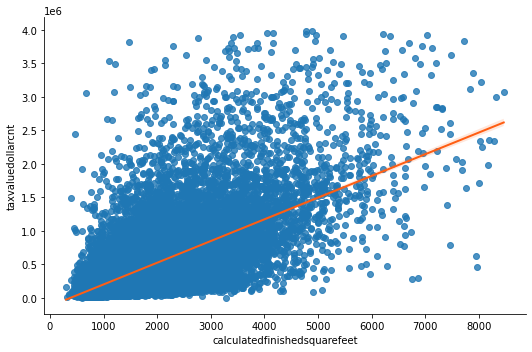

In [14]:
sns.lmplot(x = 'calculatedfinishedsquarefeet', y = 'taxvaluedollarcnt', data = train, line_kws={'color': '#FF5E13', 'linewidth': 2},  height=5, aspect=1.5)
plt.show()

In [15]:
corr, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)
p < alpha, corr

(True, 0.6155847381399193)

I reject the null hypothesis. There is a statistically significant linear correlation between calculatedfinishedsquarefeet and taxvaluedollarcnt; this relationship is moderately strong with an r value of .62, so what I saw represented above is confirmed to be statistically valid to use in our model. This is good as it's the strongest general feature observed.

##### Hypothesis 3

$H_{0}$ There is no linear correlation between yearbuilt and taxvaluedollarcnt.

$H_{a}$ There is a linear correlation between yearbuilt and taxvaluedollarcnt.

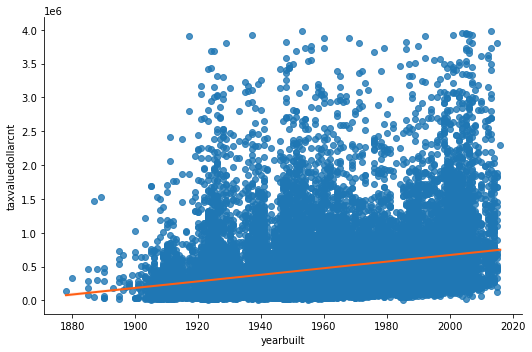

In [16]:
sns.lmplot(x = 'yearbuilt', y = 'taxvaluedollarcnt', data = train, line_kws={'color': '#FF5E13', 'linewidth': 2},  height=5, aspect=1.5)
plt.show()

In [17]:
corr, p = stats.pearsonr(train.yearbuilt, train.taxvaluedollarcnt)
p < alpha, corr

(True, 0.23338338817710566)

I reject the null hypothesis. There is a statistically significant linear correlation between yearbuilt and taxvaluedollarcnt; this relationship while existant is not very strong with an r value of .23. 

Despite statistical significance, it's not a very strong correlation. I want to do a further test below to see if there is a statistically significant correlation between yearbuilt and taxvaluedollarcnt for homes in Orange and Ventura counties like I saw above.

##### Hypothesis 4

$H_{0}$ There is no linear correlation between yearbuilt and taxvaluedollarcnt for homes in Orange and Ventura county.

$H_{a}$ There is a linear correlation between yearbuilt and taxvaluedollarcnt for homes in Orange and Ventura county.

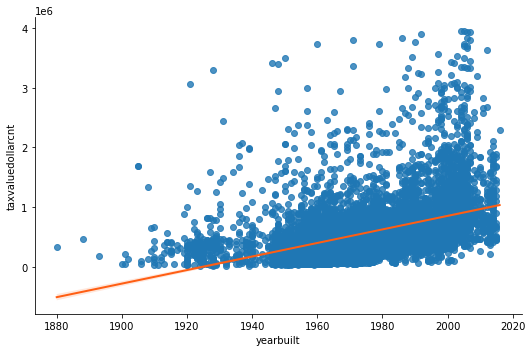

In [18]:
sns.lmplot(x = 'yearbuilt', y = 'taxvaluedollarcnt', data = orange_ventura, line_kws={'color': '#FF5E13', 'linewidth': 2},  height=5, aspect=1.5)
plt.show()

In [19]:
corr, p = stats.pearsonr(orange_ventura.yearbuilt, orange_ventura.taxvaluedollarcnt)
p < alpha, corr

(True, 0.44323311910245433)

I reject the null hypothesis. There is a statistically significant linear correlation between yearbuilt and taxvaluedollarcnt for homes in Orange and Ventura county; this relationship is noticeably stronger at .44 that the overall relationship of .23 which included Los Angeles county. 

### Hypothesis testing Takeaways

1. Homes in LA have an lower average taxvaluedollarcnt than homes in Ventura and Orange county.
2. The strongest linear correlation was calculatedfinishedsquarefeet and has been determined to be statistically significant so I will be using it for my model.
3. While yearbuilt does not have a strong correlation for the entire dataset, it becomes more robust when Los Angeles county is taken out of the calculations. This supports my idea that separating out counties could result in better individual models as there is data which is correlated more/less depending on county.

## Exploration Takeaways
- calculatedfinishedsquarefeet has the tightest correlation to the target variable. This is probably the best predictor and driver for final home value in my dataset.
- There are statistically significant differences between counties in how features are correlated to the target variable.
    - When separated by county Los Angeles county seems to have the weakest correlations between features and target.
- It will be valuable to build an overall predictive model but the construct individual models for each county and compare results.

# Modeling

I initially used a variety of models to see what gives the best results.
    

In [20]:
model_results = pd.read_csv('model_results.csv')
model_results

,model,train_RMSE,validate_RMSE
0,train_mean,477010.2000,479022.1900
1,train_median,491569.8000,492880.6900
2,linear_regression_ols,367980.6554,369039.8772
3,lasso_lars,367980.8981,369041.8822
4,tweedie_regressor_glm,389552.3893,388018.0318
5,polynomial_regression,364349.5674,365217.6465
6,ridge_regressor,367983.4645,369072.5991
7,sgd_regressor,368323.8206,369760.0555
8,ard_regressor,367980.6780,369038.5611
9,bayesian_ridge,367980.6632,369041.4706


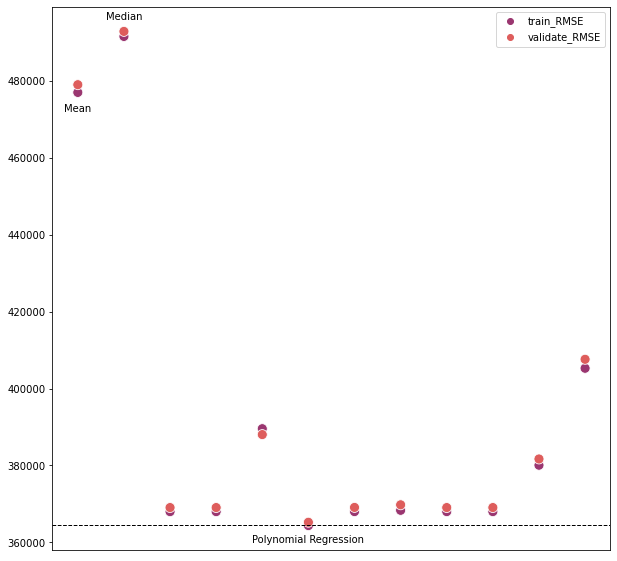

In [21]:
model.plot_all_models(model_results)

- Mean RMSE on Validate: \$479,022.19
- Median RMSE on Validate: \$492,880.69


**Polynomial Regression RMSE on Validate: \$365,217.65**

This is an improvement over the Mean baseline of **\$113,804.54**

#### Further modeling

My polynomial Regression model is my new baseline. I want to go back to my train_scaled, validate_scaled, and test_scaled subsets and separate them out by county in order to see if I can create 3 new models which perform individually better than the baseline.

In [22]:
# Separating train, validate, test out by county
train_la, train_orange, train_ventura = model.county_train_split(train_scaled)

validate_la, validate_orange, validate_ventura = model.county_validate_split(validate_scaled)

test_la, test_orange, test_ventura = model.county_validate_split(test_scaled)

For this, I'm going to add in some features that were better predictors for Orange and Ventura counties to see how they improve the model; I'm also going to add these features into Los Angeles county to see how it affects the model.

In [23]:
# Adding lotsizesquarefeet and yearbuilt, and defining X and y for each county train subset
X_train_la, y_train_la, X_train_orange, y_train_orange, X_train_ventura, y_train_ventura = \
    model.county_train_x_y(train_la, train_orange, train_ventura)

# Adding lotsizesquarefeet and yearbuilt, and defining X and y for each county validate subset
X_validate_la, y_validate_la, X_validate_orange, y_validate_orange, X_validate_ventura, y_validate_ventura = \
    model.county_validate_x_y(validate_la, validate_orange, validate_ventura)

# Adding lotsizesquarefeet and yearbuilt, and defining X and y for each county test subset
X_test_la, y_test_la, X_test_orange, y_test_orange, X_test_ventura, y_test_ventura = \
    model.county_test_x_y(test_la, test_orange, test_ventura)

**Training and validating for Los Angeles County model**

In [24]:
y_train_la, y_validate_la, y_test_la = \
    model.la_county_model(X_train_la, y_train_la, X_validate_la, y_validate_la, X_test_la, y_test_la)


RMSE for Polynomial Model for LA county

Training/In-Sample:  375023.72334097576 
Validation/Out-of-Sample:  376159.6203252768


The individual model for Los Angeles County a slightly worse than the baseline model above.

**Training and validating for Orange County model**

In [25]:
y_train_orange, y_validate_orange, y_test_orange = \
    model.orange_county_model(X_train_orange, y_train_orange, X_validate_orange, y_validate_orange, X_test_orange, y_test_orange)


RMSE for Polynomial Model for Orange county

Training/In-Sample:  343852.54942392476 
Validation/Out-of-Sample:  346354.63713526935


The individual model for Orange County a slightly better than the baseline model above.

**Training and validating for Ventura County model**

In [26]:
y_train_ventura, y_validate_ventura, y_test_ventura = \
    model.ventura_county_model(X_train_ventura, y_train_ventura, X_validate_ventura, y_validate_ventura, X_test_ventura, y_test_ventura)


RMSE for Polynomial Model for Orange county

Training/In-Sample:  213924.58367415334 
Validation/Out-of-Sample:  254042.85275017304


The individual model for Ventura County was *significantly* better than the baseline model above.

**Verifying the models on test**

In [27]:
model.county_models_test(y_test_la, y_test_orange, y_test_ventura)


RMSE for Polynomial Model for Los Angeles county
\Test/Out-of-Ssample:  368333.99640893657

RMSE for Polynomial Model for Orange county
\Test/Out-of-Ssample:  309071.3777638292

RMSE for Polynomial Model for Ventura county
\Test/Out-of-Ssample:  233689.5022497083


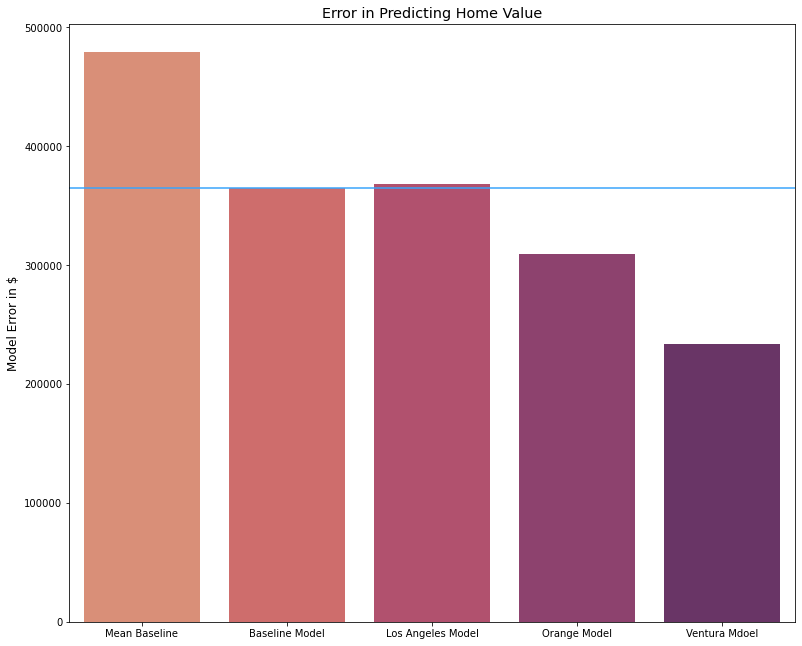

In [28]:
# Visualizing the model results on test below
model.results_plot()

## Modeling Final Takeaways

The best performing model I arrived at was actually a split of 3 models each one specific for each county; all models were polynomial regression models with a degree of 2. See how the actual prices compare to the predicted prices below.

# Conclusions, Recommendations, Next Steps
I developed a ML Regression model that beat the mean baseline in every category.
- Certain features that I suspected would drive property value were not as strong predictors as I expected; however they were still useful.
- Los Angeles county has such a spread of data that none of the features I had access to in the database were truly strong predictors.
    - **Recommend a follow up study involving the data science team and realty team explore this problem and find creative solutions which might deliver more useful features for a future model.**
    
##### Smaller subsets of like homes are better predictors for the target of tax value; we should make more specialized models than one uber "do-it-all" model.

##### We need more accurate reporting on listing creation from realtors if we want to be able to develop better performing models.
- It would be nice to know the following datapoints to see if they are useful features:
    - Total time on market
    - Crime rate of neighborhood
    - Surrounding schools' ratings
    - Mean Property Value of surrounding neighborhood
    - Distance to city center
    - Percentage of homes in surrounding neighbhorhood that are rental properties
- Given more time, I'd like to further refine these subgroupings and create more specific models that better represent the data for each.